In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy 

import textwrap

import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../../..')
# print(root_path)
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data

# Import linear synthetic data creation
from causaltune.datasets import generate_linear_synthetic_data

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# set a few params
metrics = [
    "frobenius_norm",
    "prob_erupt",
    "policy_risk",
    "codec",
    "energy_distance", 
    "psw_energy_distance"
    ]

iv_metrics = [
    "frobenius_norm",       
    "energy_distance",      
    "codec",                
    ]
    
n_samples = 100
test_size = 0.33 # equal train,val,test
#time_budget = 21600
components_time_budget = 10

estimator_list = [
             #"Dummy",
             "SparseLinearDML",
             "ForestDRLearner",
             "TransformedOutcome",
             "CausalForestDML",
             ".LinearDML",
             "DomainAdaptationLearner",
             #"SLearner",
             "XLearner",
             #"TLearner",
             #"Ortho"        
            ] 

iv_estimator_list = [
                'iv.econml.iv.dr.LinearDRIV', 
                'iv.econml.iv.dml.OrthoIV', 
                'iv.econml.iv.dml.DMLIV',
                'iv.econml.iv.dr.SparseLinearDRIV',
                'iv.econml.iv.dr.LinearIntentToTreatDRIV'
                ] 

n_runs = 1
out_dir = ""
filename_out = "iv"

# 1. Dataset Generation

In [3]:
# Create empty dictionary
data_sets = {}

### 1.1 Non-linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [4]:
#cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
#cd_non_linear.preprocess_dataset()
#data_sets['rct_non-linear'] = cd_non_linear

In [5]:
#cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
#cd_non_linear.preprocess_dataset()
#data_sets['known_confounders_non-linear'] = cd_non_linear

In [6]:
cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
cd_non_linear.preprocess_dataset()
data_sets['IV_non-linear'] = cd_non_linear

### 1.2 Linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [7]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
#cd_linear.preprocess_dataset()
#data_sets['rct_linear'] = cd_linear

In [8]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
#cd_linear.preprocess_dataset()
#data_sets['known_confounders_linear'] = cd_linear

In [9]:
cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
cd_linear.preprocess_dataset()
data_sets['IV_linear'] = cd_linear
cd_linear.data.head(5)

,treatment,outcome,true_effect,base_outcome,instrument,random,X1,X2,X3,X4,X5,propensity
0,0,0.450543,1.289024,0.450543,1,0.0,-0.076146,-0.132621,0.419829,1.496246,0.094485,0.219328
1,0,0.156640,0.483619,0.156640,0,1.0,-0.824938,0.618384,0.111048,1.294570,-0.694036,0.544131
2,0,-0.468900,-1.123213,-0.468900,0,1.0,-0.084203,-0.998936,0.038287,-0.766497,-0.299085,0.450420
3,1,-2.290974,-1.580341,-0.710633,1,0.0,-0.072053,-0.549470,-1.041654,-0.865283,-0.379514,0.900000
4,0,0.044335,0.216895,0.044335,0,0.0,-0.130618,1.086328,-0.431098,0.116885,-0.314361,0.807708


# 2. Model Fitting

In [89]:
for dataset_name, cd in data_sets.items():
    
    for i_run in range(1,n_runs+1):
        
        cd_i = copy.deepcopy(cd)
        train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
        test_df = test_df.reset_index(drop=True)
        cd_i.data = train_df
        
        #for metric in metrics:
        for metric in iv_metrics:
            ct = CausalTune(
                metric=metric,
                metrics_to_report=[metric],
                verbose=1,
                components_verbose=1,
                components_time_budget=components_time_budget,
                #estimator_list=estimator_list,
                estimator_list=iv_estimator_list,
                store_all_estimators=True,
            )

            ct.fit(
                data=cd_i,
                treatment="treatment",
                outcome="outcome",
            )

            # compute relevant scores (skip newdummy)
            datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
            for trial in ct.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ct.scorer.make_scores(
                            estimator,
                            df,
                            metrics_to_report=ct.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    estimator_scores[estimator_name].append(scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric in ["energy_distance", "psw_energy_distance", "codec"] else True,
                )
            results = {
                "best_estimator": ct.best_estimator,
                "best_config": ct.best_config,
                "best_score": ct.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
            }


            with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}_{dataset_name}.pkl", "wb") as f:
                pickle.dump(results, f)

[flaml.tune.tune: 07-24 17:51:47] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-24 17:51:47] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.tune.tune: 07-24 17:52:27] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'train': {'frobenius_norm': 1.7061476082509759}, 'validation': {'frobenius_norm': 1.8133158981000745}}


[flaml.tune.tune: 07-24 17:52:47] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'train': {'frobenius_norm': 1.5240321859227073}, 'validation': {'frobenius_norm': 1.2537755378872513}}


[flaml.tune.tune: 07-24 17:53:07] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.DMLIV', 'train': {'frobenius_norm': 1.4503309515531349}, 'validation': {'frobenius_norm': 2.1334819838273797}}


[flaml.tune.tune: 07-24 17:53:48] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'train': {'frobenius_norm': 2.0273869220789993}, 'validation': {'frobenius_norm': 1.6487019570997452}}


[flaml.tune.tune: 07-24 17:54:49] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-24 17:54:49] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'train': {'frobenius_norm': 1.469078660688006}, 'validation': {'frobenius_norm': 1.2767739128957123}}
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.tune.tune: 07-24 17:55:29] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'train': {'energy_distance': 1.2342694730438208}, 'validation': {'energy_distance': 3.581697941996879}}


[flaml.tune.tune: 07-24 17:55:49] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'train': {'energy_distance': 0.26447111116414446}, 'validation': {'energy_distance': 1.8041461329277957}}


[flaml.tune.tune: 07-24 17:56:10] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.DMLIV', 'train': {'energy_distance': 0.28117313378506426}, 'validation': {'energy_distance': 0.873065452526324}}


[flaml.tune.tune: 07-24 17:56:50] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'train': {'energy_distance': 0.20387149159602824}, 'validation': {'energy_distance': 0.7661351736217683}}


[flaml.tune.tune: 07-24 17:57:51] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-24 17:57:51] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'train': {'energy_distance': 0.20716529061236866}, 'validation': {'energy_distance': 0.8863925741834082}}
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.tune.tune: 07-24 17:58:31] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'train': {'codec': 0.008658008658008658}, 'validation': {'codec': 0.0}}


[flaml.tune.tune: 07-24 17:58:51] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'train': {'codec': 0.08900523560209424}, 'validation': {'codec': 0.0}}


[flaml.tune.tune: 07-24 17:59:12] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.DMLIV', 'train': {'codec': 0.07894736842105264}, 'validation': {'codec': 0.0}}


[flaml.tune.tune: 07-24 17:59:52] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'train': {'codec': 0.05365853658536586}, 'validation': {'codec': 0.0}}


[flaml.tune.tune: 07-24 18:00:53] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-24 18:00:53] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'train': {'codec': 0.008695652173913044}, 'validation': {'codec': 0.0}}
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.tune.tune: 07-24 18:01:33] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'train': {'frobenius_norm': 1.7238523719841985}, 'validation': {'frobenius_norm': 1.2998893813992485}}


[flaml.tune.tune: 07-24 18:01:54] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'train': {'frobenius_norm': 1.5951272809656039}, 'validation': {'frobenius_norm': 1.0673157380063014}}


[flaml.tune.tune: 07-24 18:02:14] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.DMLIV', 'train': {'frobenius_norm': 1.5749917488367353}, 'validation': {'frobenius_norm': 1.1209231659854761}}


[flaml.tune.tune: 07-24 18:02:54] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'train': {'frobenius_norm': 1.7497389879147947}, 'validation': {'frobenius_norm': 1.4443528602451912}}


[flaml.tune.tune: 07-24 18:03:55] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-24 18:03:55] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'train': {'frobenius_norm': 1.615607024139133}, 'validation': {'frobenius_norm': 1.1343300656833482}}
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.tune.tune: 07-24 18:04:36] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'train': {'energy_distance': 0.23724020051138384}, 'validation': {'energy_distance': 1.2377427037908548}}


[flaml.tune.tune: 07-24 18:04:56] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'train': {'energy_distance': 0.252395428844979}, 'validation': {'energy_distance': 1.2199628927910995}}


[flaml.tune.tune: 07-24 18:05:16] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.DMLIV', 'train': {'energy_distance': 0.2526835825297922}, 'validation': {'energy_distance': 1.2201602220588965}}


[flaml.tune.tune: 07-24 18:05:56] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'train': {'energy_distance': 0.2677465290200698}, 'validation': {'energy_distance': 1.260878360107383}}


[flaml.tune.tune: 07-24 18:06:57] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-24 18:06:57] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'train': {'energy_distance': 0.2590631341798373}, 'validation': {'energy_distance': 1.2301493868146594}}
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.tune.tune: 07-24 18:07:38] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'train': {'codec': 0.05142857142857143}, 'validation': {'codec': 0.0}}


[flaml.tune.tune: 07-24 18:07:58] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'train': {'codec': 0.18991097922848665}, 'validation': {'codec': 0.0}}


[flaml.tune.tune: 07-24 18:08:18] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dml.DMLIV', 'train': {'codec': -0.0033333333333333335}, 'validation': {'codec': 0.0}}


[flaml.tune.tune: 07-24 18:08:59] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}


after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'train': {'codec': 0.01342281879194631}, 'validation': {'codec': 0.0}}
after estimate
after setting score dictionary
{'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'train': {'codec': 0.05654761904761905}, 'validation': {'codec': 0.0}}


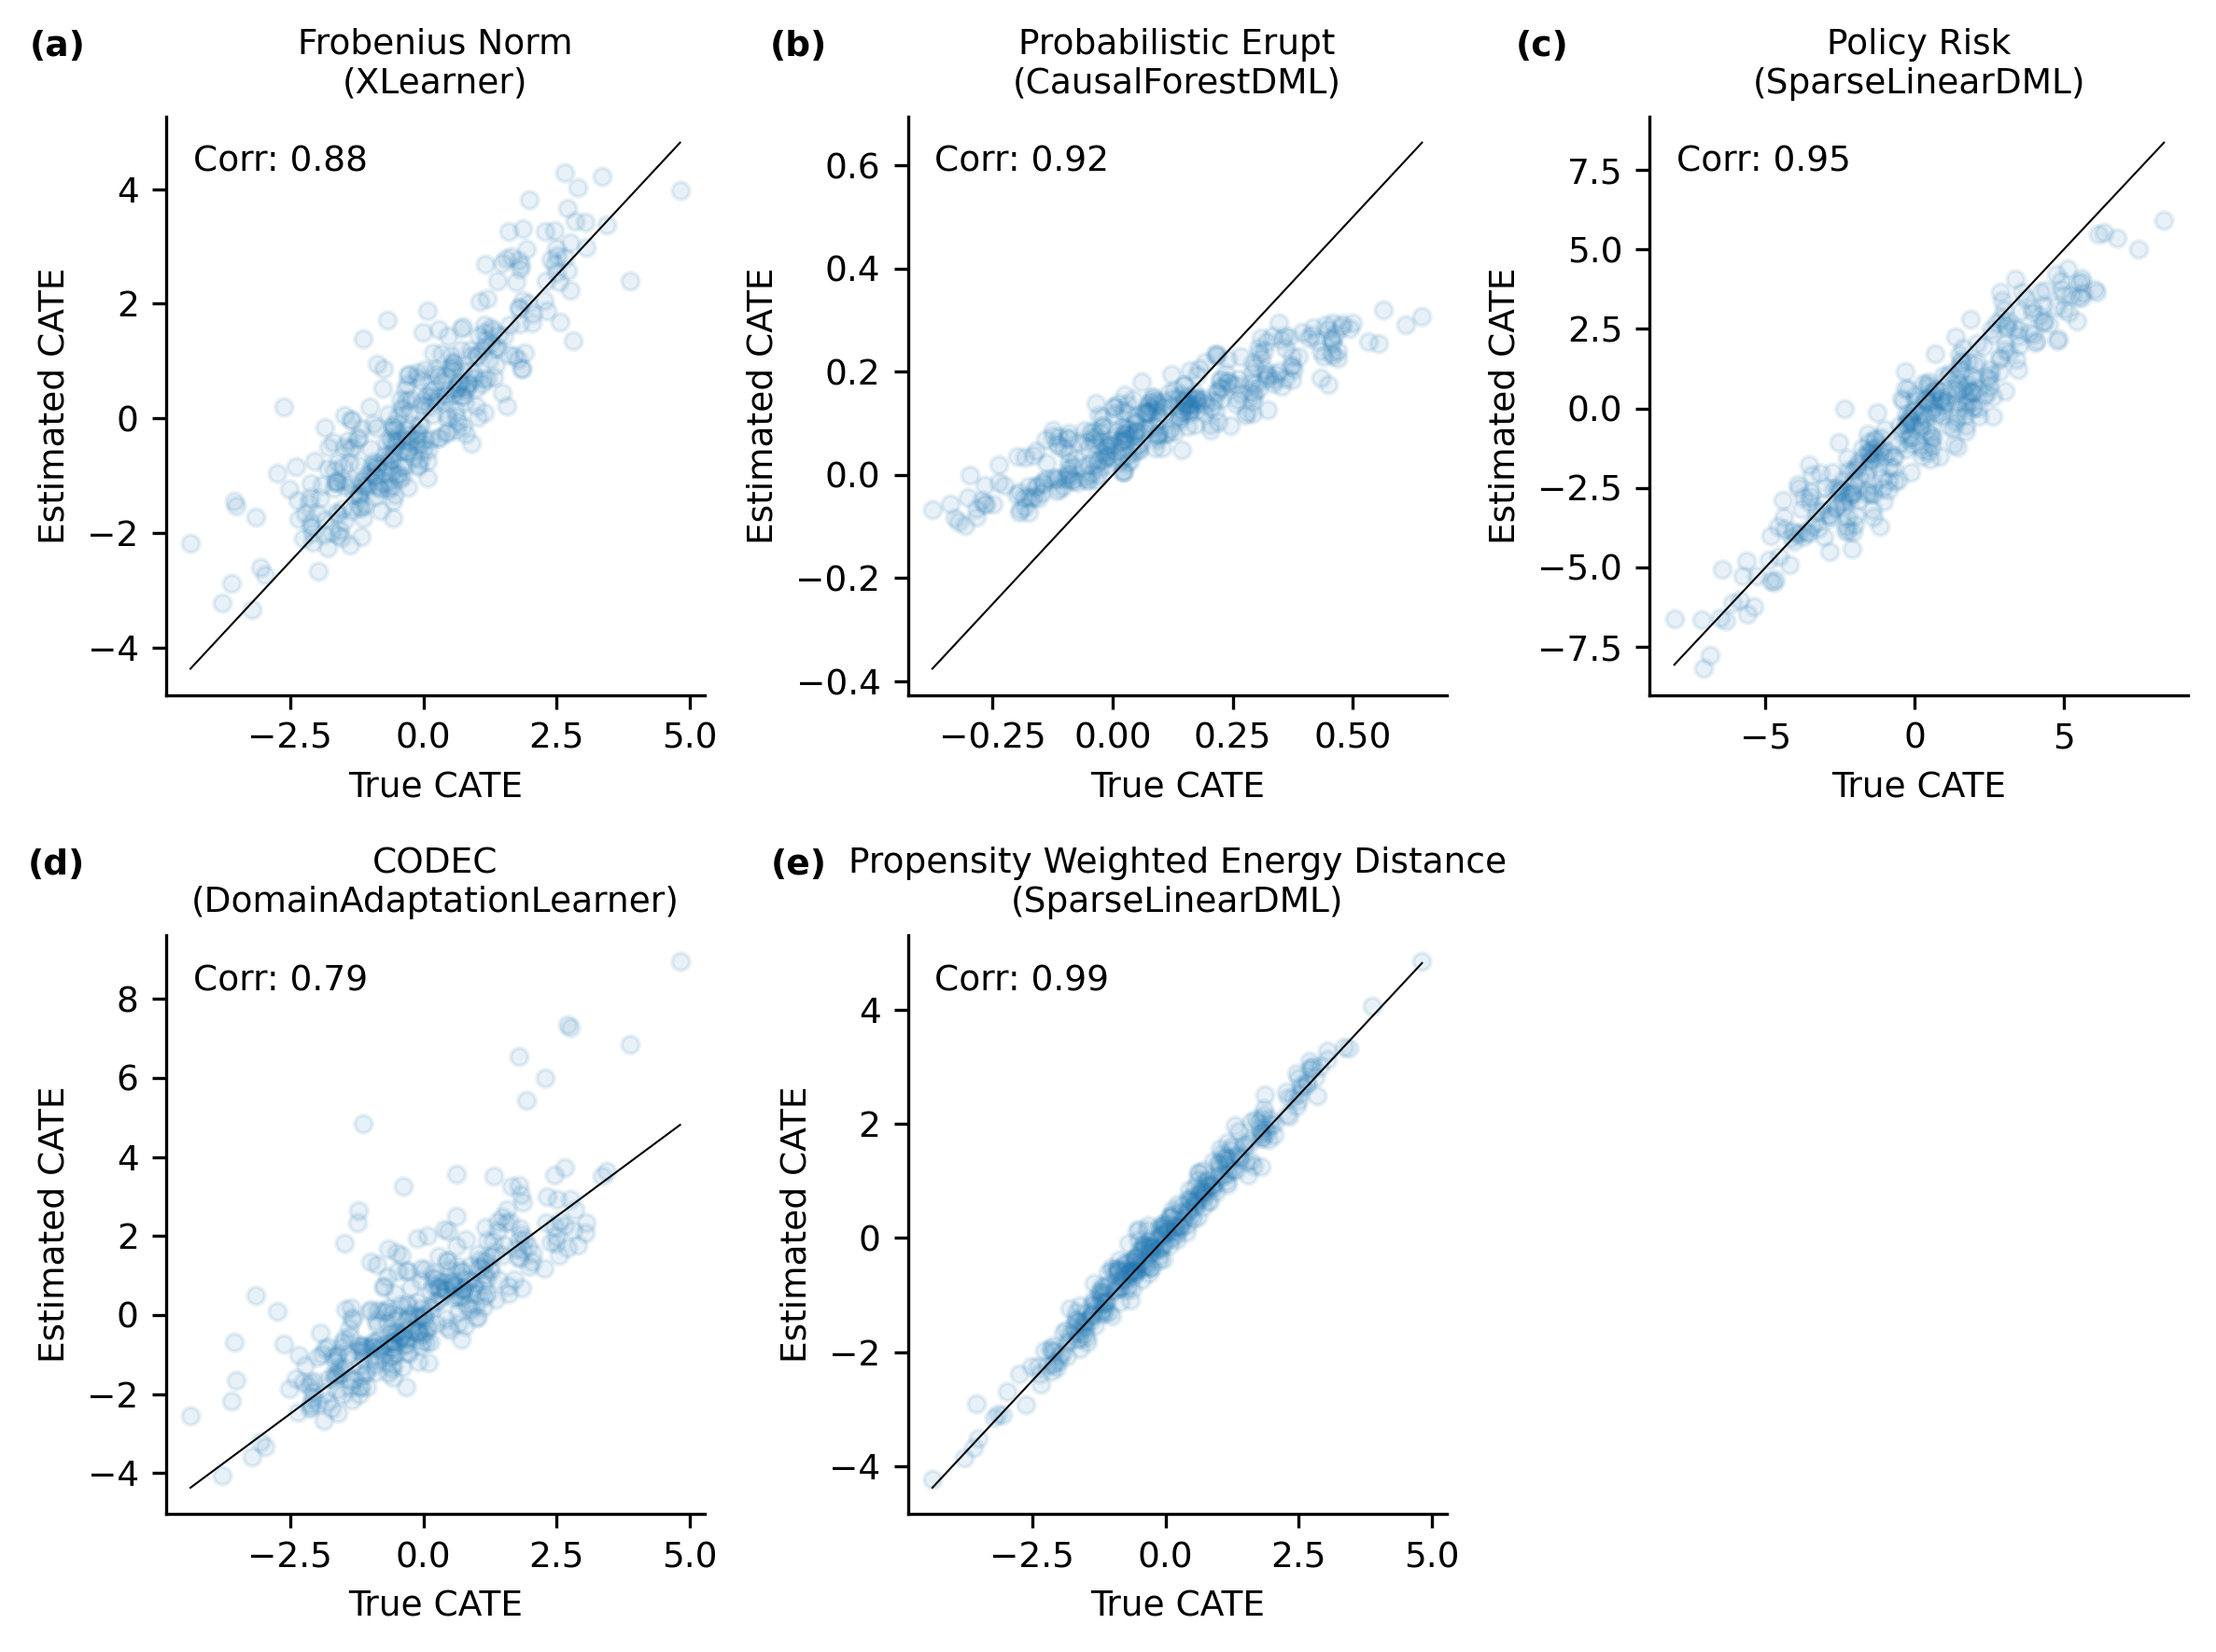

In [6]:
import matplotlib.pyplot as plt
import pickle
import textwrap
import numpy as np

### Define list of experiments and metrics

# IV
# trials = ['IV_non-linear']
# metrics = ['frobenius_norm', 'energy_distance', 'codec']
# no_rows = 1

# RCT
trials = ['rct_non-linear']
metrics = ["frobenius_norm", "prob_erupt", "policy_risk", "codec", "psw_energy_distance"]
no_rows = 2

# Known Confounders
# trials = ['known_confounders_linear']
# metrics = ["frobenius_norm", "prob_erupt", "policy_risk", "codec", "psw_energy_distance"]
# no_rows = 2


### Plot formatting and creation
no_col = 3
fontsize = 9
fig, axs = plt.subplots(no_rows, no_col, figsize=(8, 3*no_rows), dpi=300)
axs = axs.flatten()


### Define names for metrics and subplots to be displayed

# IV
# metric_names = ['Frobenius Norm', 'Energy Distance', 'CODEC']
# subplot_labels = ['(a)', '(b)', '(c)']

# RCT / KC
metric_names = ['Frobenius Norm', 'Probabilistic Erupt', 'Policy Risk', 'CODEC', 'Propensity Weighted Energy Distance']
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']



# Plot true against estimated for best estimator
for i, (trial, metric) in enumerate([(t, m) for t in trials for m in metrics]):
    ax = axs[i]
    
    # IV
    #filename = f"iv_600_{metric}_run_1_{trial}.pkl"
    #with open(f"iv/{filename}", "rb") as f:
    #   results = pickle.load(f)
    
    # RCT
    #filename = f"linear_600_{metric}_run_1_{trial}.pkl"
    filename = f"non_linear_600_{metric}_run_1_{trial}.pkl"
    with open(f"rct/{filename}", "rb") as f:
        results = pickle.load(f)

    # KC
    #filename = f"linear_600_{metric}_run_1_{trial}.pkl"
    #filename = f"non_linear_600_{metric}_run_1_{trial}.pkl"
    #with open(f"known_confounders/{filename}", "rb") as f:
    #    results = pickle.load(f)
    
    best_estimator = results["best_estimator"]
    CATE_gt = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_groundtruth"]
    CATE_est = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_estimate"]
    
    # Plot
    ax.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
    ax.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)
    
    ax.set_xlabel("True CATE", fontsize = fontsize)
    ax.set_ylabel("Estimated CATE", fontsize = fontsize)
    
    ax.set_title(f"{metric_names[i]}\n({best_estimator.split('.')[-1]})", fontsize = fontsize)

    # Change the fontsize of the x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize)


    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add correlation coefficient
    cate_gt_for_cor = list(CATE_gt)
    try:
        cate_est_for_cor = CATE_est[:,0]
    except:
        cate_est_for_cor = CATE_est

    corr = np.corrcoef(cate_gt_for_cor, cate_est_for_cor)[0, 1]

    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=fontsize)

    # IV
    #ax.text(-0.15, 1.15, subplot_labels[i], transform=ax.transAxes,
    #        fontsize=fontsize, fontweight='bold', va='top', ha='right')

    # RCT and Knwon Confoudners subplot label
    ax.text(-0.15, 1.15, subplot_labels[i], transform=ax.transAxes,
            fontsize=fontsize, fontweight='bold', va='top', ha='right')

# RCT and Knwon Confoudners
# Hide the last subplot (bottom right)
fig.delaxes(axs[-1]) 

plt.tight_layout()
plt.savefig("all_metrics_comparison.pdf", format="pdf")
plt.show()

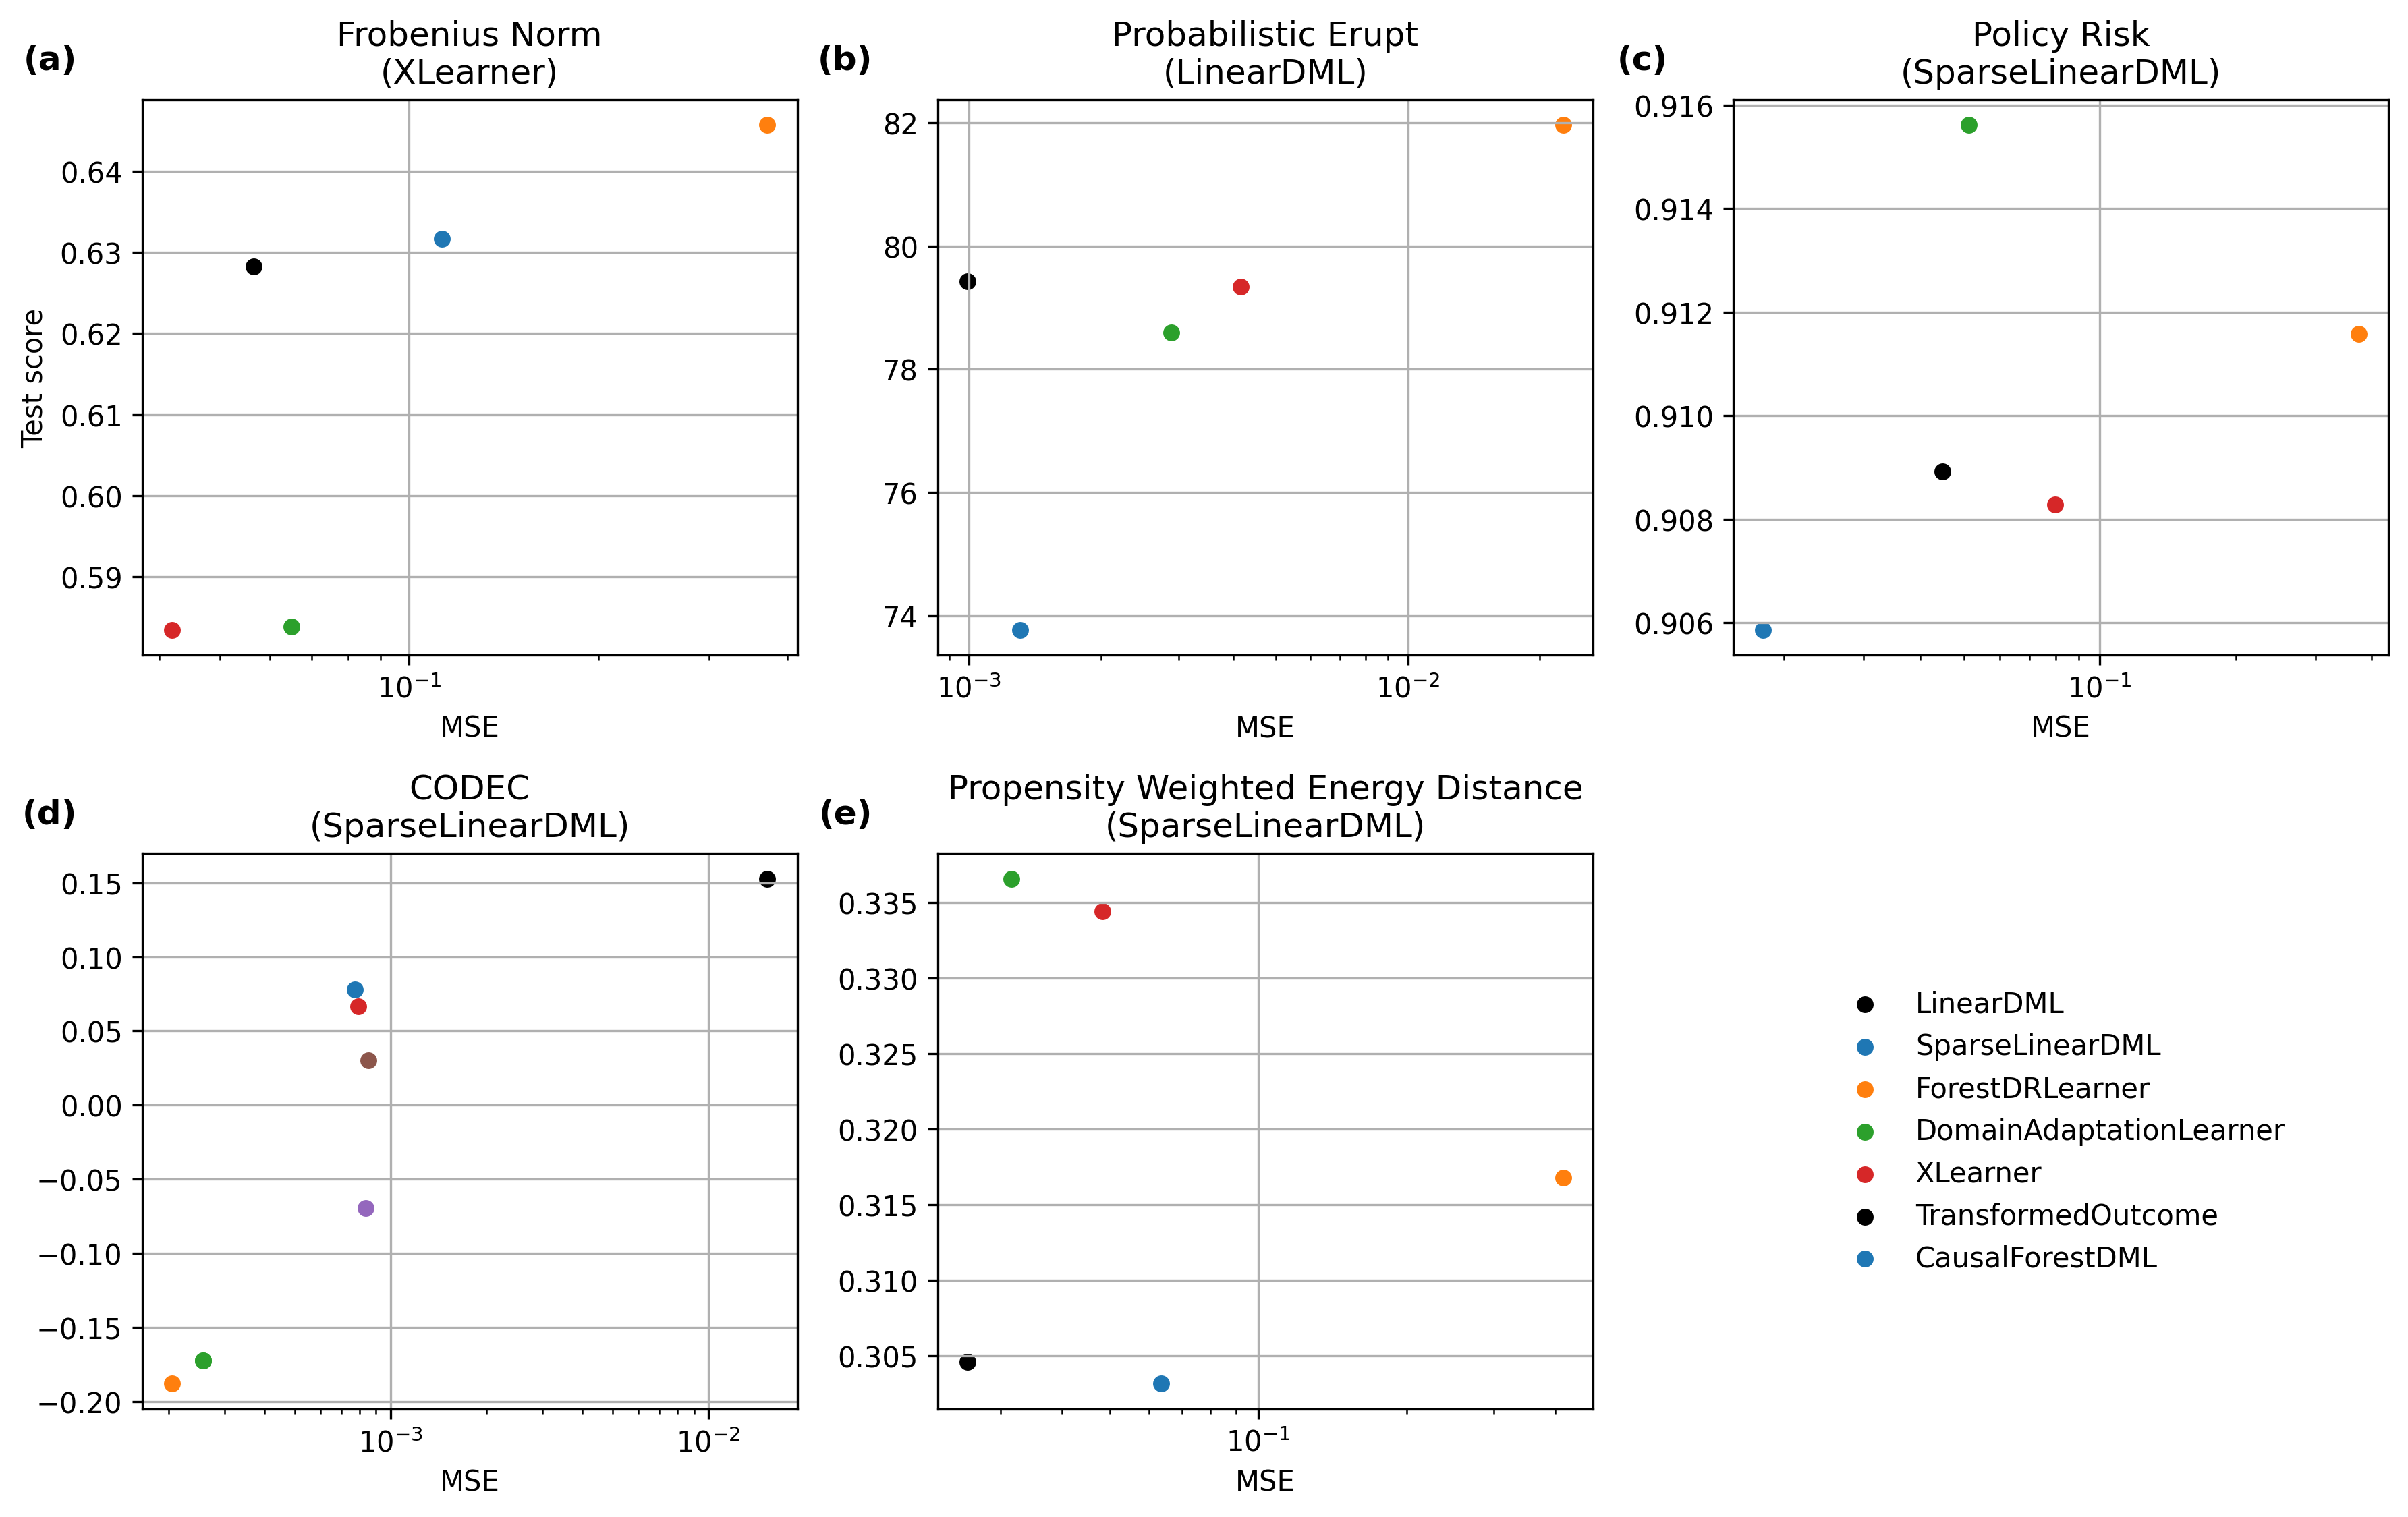

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import colorsys

# Define list of trials and metrics

# RCT
# trials = ['rct_linear']
# metrics = ["frobenius_norm", "prob_erupt", "policy_risk", "codec", "psw_energy_distance"]
# no_rows = 2

# KC
trials = ['known_confounders_linear']
metrics = ["frobenius_norm", "prob_erupt", "policy_risk", "codec", "psw_energy_distance"]
no_rows = 2

# IV
# trials = ['IV_linear']
# metrics = ["frobenius_norm", "codec", "energy_distance"]
# no_rows = 1


### Plot formatting and creation
no_col = 3
fontsize = 9
fig, axs = plt.subplots(no_rows, no_col, figsize=(12, 8), dpi=300)

axs = axs.flatten()


### Define names for metrics and subplots to be displayed

# IV
# metric_names = ['Frobenius Norm', 'Energy Distance', 'CODEC']
# subplot_labels = ['(a)', '(b)', '(c)']

# RCT / KC
metric_names = ['Frobenius Norm', 'Probabilistic Erupt', 'Policy Risk', 'CODEC', 'Propensity Weighted Energy Distance']
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']


colors = ([matplotlib.colors.CSS4_COLORS['black']] +
          list(matplotlib.colors.TABLEAU_COLORS) + [
              matplotlib.colors.CSS4_COLORS['lime'],
              matplotlib.colors.CSS4_COLORS['yellow'],
              matplotlib.colors.CSS4_COLORS['pink']
          ])

def scale_lightness(rgb, scale_l):
    # Convert RGB to HLS and adjust lightness
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s)

all_handles = []
all_labels = []

for row, trial in enumerate(trials):
    for col, metric in enumerate(metrics):
        ax = axs[col] 
        
        filename = f"known_confounders/linear_600_{metric}_run_1_{trial}.pkl" # to be changed for different plots
        with open(filename, "rb") as f:
            results = pickle.load(f)
        
        for idx, (est_name, scr) in enumerate(results["scores_per_estimator"].items()):
            if "Dummy" not in est_name:
                if len(scr):
                    # Plot intermediate runs
                    if len(scr) > 1:
                        lightness = np.linspace(1, 2.8, len(scr))
                        col_rgb = matplotlib.colors.ColorConverter.to_rgb(colors[idx])
                        for i_run in range(1, len(scr)):
                            CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                            CATE_est = scr[i_run]["test"]["CATE_estimate"]
                            CATE_gt = np.array(CATE_gt).flatten()
                            CATE_est = np.array(CATE_est).flatten()
                            mse = np.mean((CATE_gt - CATE_est)**2)
                            score = scr[i_run]["test"][metric]
                            ax.scatter(mse, score, color=scale_lightness(col_rgb, lightness[i_run-1]), s=30, linewidths=0.5, label="nolegend")
                    
                    # Plot best estimator
                    CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                    CATE_est = scr[0]["test"]["CATE_estimate"]
                    CATE_gt = np.array(CATE_gt).flatten()
                    CATE_est = np.array(CATE_est).flatten()
                    mse = np.mean((CATE_gt - CATE_est)**2)
                    score = scr[0]["test"][metric]
                    scatter = ax.scatter(mse, score, color=colors[idx], s=30, linewidths=0.5)
                    
                    # Collect handles and labels for the overarching legend
                    handle = scatter
                    label = est_name.split(".")[-1]
                    if label not in all_labels:
                        all_handles.append(handle)
                        all_labels.append(label)

        # Add bold subplot labels
        ax.text(-0.1, 1.1, subplot_labels[col], transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='right')
        
        if col == 0:
            ax.set_ylabel("Test score")
        ax.set_xlabel("MSE")
        best_estimator = results["best_estimator"]
        ax.set_title(f"{metric_names[col]}\n({best_estimator.split('.')[-1]})")
        ax.set_xscale("log")
        ax.grid(True)

# Add legend in the last (empty) subplot
axs[-1].legend(all_handles, all_labels, loc='center', frameon=False)
axs[-1].axis('off')  # Hide the axis of the legend subplot

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("all_metrics_mse_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

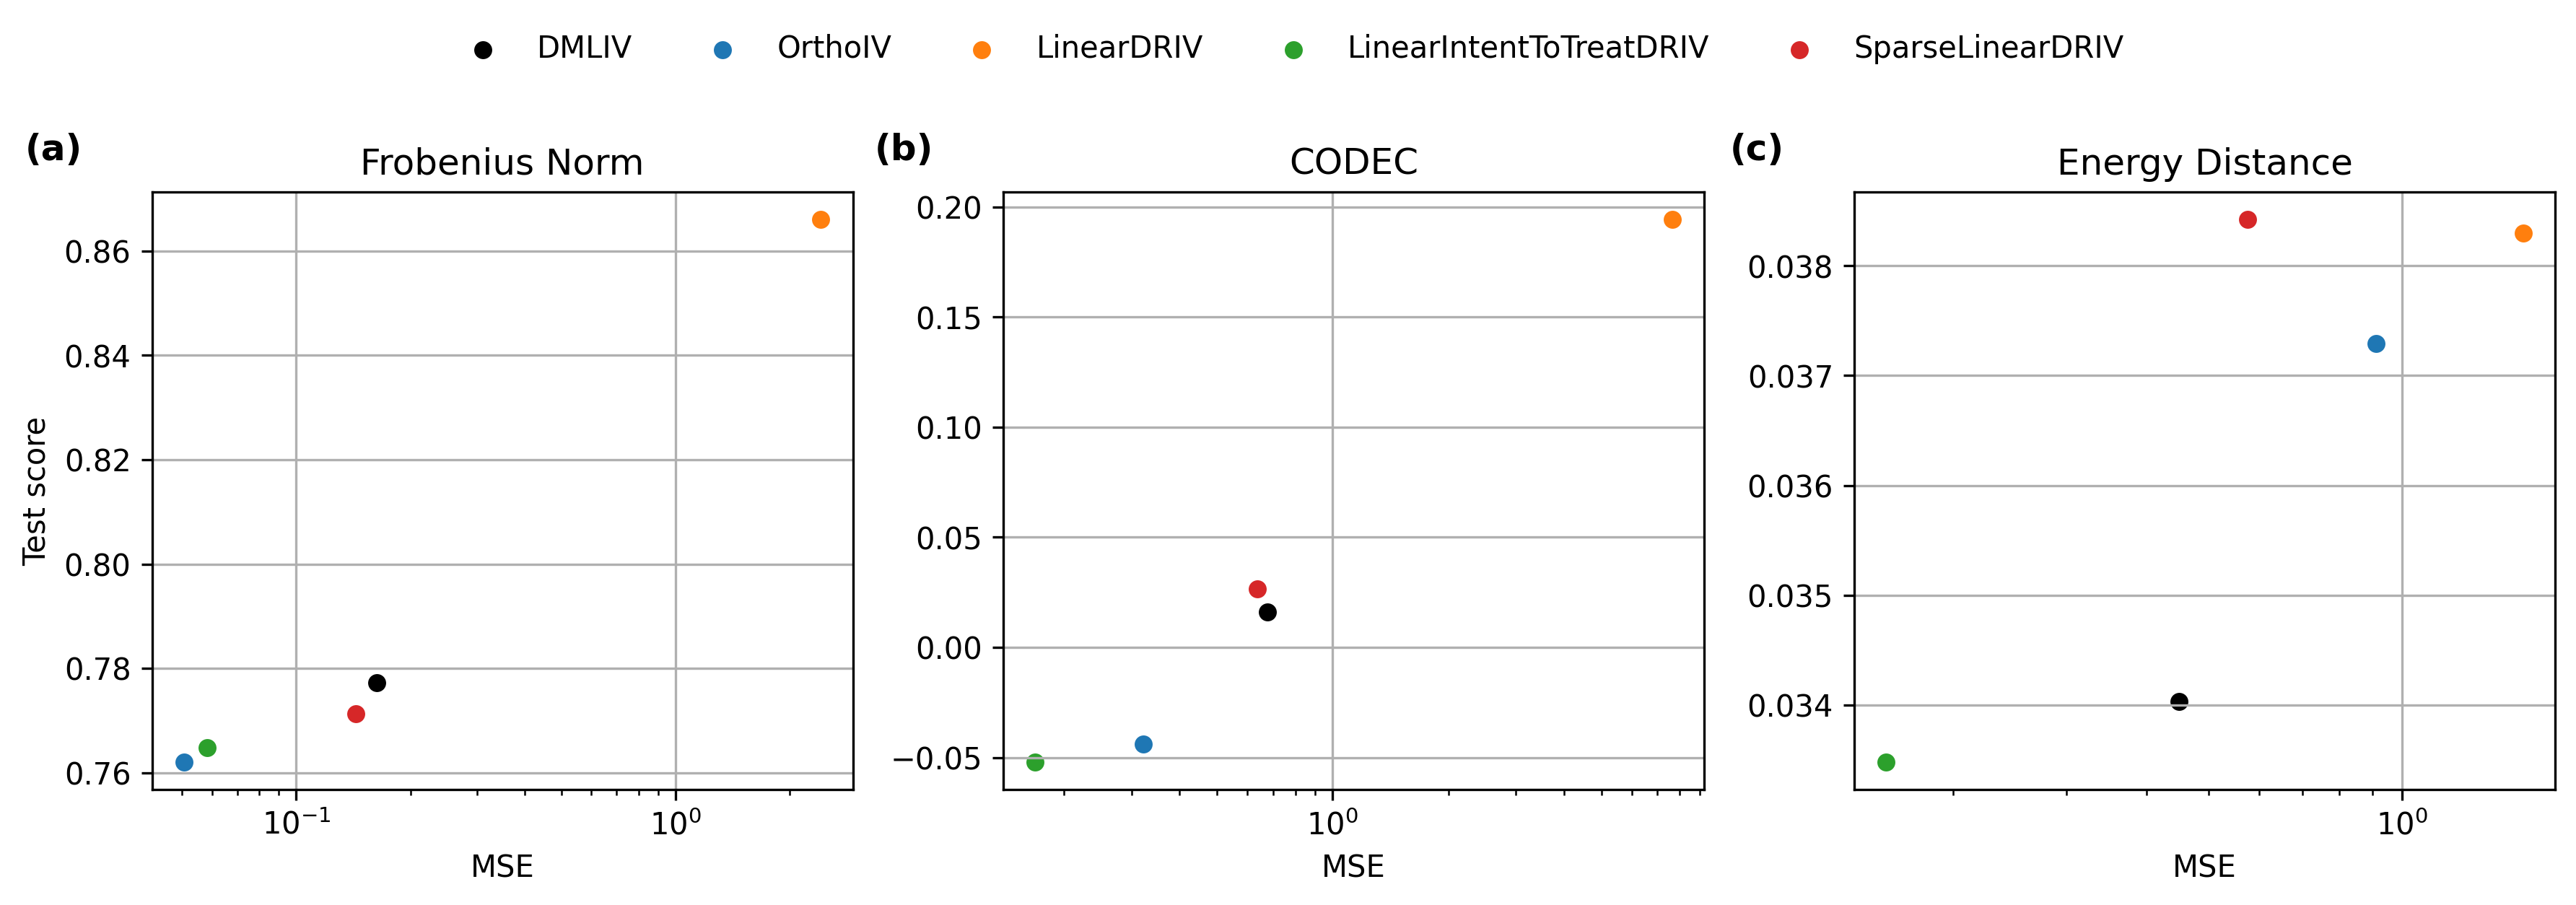

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import colorsys

# Define list of experiments and metrics
trials = ['IV_non-linear']
metrics = ["frobenius_norm", "codec", "energy_distance"]

# Set up the plot
# IV
no_rows = 1 if len(metrics) <= 3 else 2
no_col = 3
fontsize = 9

# Create subplots
fig, axs = plt.subplots(no_rows, no_col, figsize=(no_col * 4, no_rows * 4), dpi=300)

# Flatten axs for easier indexing, and ensure axs is an array
axs = axs.flatten()

# Metric names for titles and subplot labels
metric_names = ['Frobenius Norm', 'CODEC', 'Energy Distance']
subplot_labels = ['(a)', '(b)', '(c)']

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
          list(matplotlib.colors.TABLEAU_COLORS) + [
              matplotlib.colors.CSS4_COLORS['lime'],
              matplotlib.colors.CSS4_COLORS['yellow'],
              matplotlib.colors.CSS4_COLORS['pink']
          ])

def scale_lightness(rgb, scale_l):
    # Convert RGB to HLS and adjust lightness
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s)

all_handles = []
all_labels = []

for row, trial in enumerate(trials):
    for col, metric in enumerate(metrics):
        ax = axs[col]
        
        filename = f"iv/iv_600_{metric}_run_1_{trial}.pkl"
        with open(filename, "rb") as f:
            results = pickle.load(f)
        
        for idx, (est_name, scr) in enumerate(results["scores_per_estimator"].items()):
            if "Dummy" not in est_name:
                if len(scr):
                    # Plot intermediate runs
                    if len(scr) > 1:
                        lightness = np.linspace(1, 2.8, len(scr))
                        col_rgb = matplotlib.colors.ColorConverter.to_rgb(colors[idx])
                        for i_run in range(1, len(scr)):
                            CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                            CATE_est = scr[i_run]["test"]["CATE_estimate"]
                            CATE_gt = np.array(CATE_gt).flatten()
                            CATE_est = np.array(CATE_est).flatten()
                            mse = np.mean((CATE_gt - CATE_est)**2)
                            score = scr[i_run]["test"][metric]
                            ax.scatter(mse, score, color=scale_lightness(col_rgb, lightness[i_run-1]), s=30, linewidths=0.5, label="nolegend")
                    
                    # Plot best estimator
                    CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                    CATE_est = scr[0]["test"]["CATE_estimate"]
                    CATE_gt = np.array(CATE_gt).flatten()
                    CATE_est = np.array(CATE_est).flatten()
                    mse = np.mean((CATE_gt - CATE_est)**2)
                    score = scr[0]["test"][metric]
                    scatter = ax.scatter(mse, score, color=colors[idx], s=30, linewidths=0.5)
                    
                    # Collect handles and labels for the overarching legend
                    handle = scatter
                    label = est_name.split(".")[-1]
                    if label not in all_labels:
                        all_handles.append(handle)
                        all_labels.append(label)

        # Add bold subplot labels
        ax.text(-0.1, 1.1, subplot_labels[col], transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='right')
        
        if col == 0:
            ax.set_ylabel("Test score")
        ax.set_xlabel("MSE")
        ax.set_title(f"{metric_names[col]}")
        ax.set_xscale("log")
        ax.grid(True)

# Place the legend
if no_rows == 1:
    # For a single row layout, place the legend above the plots
    fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(all_labels), frameon=False)
else:
    # Add legend in the last (empty) subplot for multiple rows layout
    axs[-1].legend(all_handles, all_labels, loc='center', frameon=False)
    axs[-1].axis('off')  # Hide the axis of the legend subplot

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to make room for the legend
plt.savefig("all_metrics_mse_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()